# NEMO upwelling postprocessing development notebook

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from matplotlib import colors
from scipy.interpolate import interp1d, griddata
from copy import copy
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import geo_tools, viz_tools
from dynmodes import dynmodes
from warnings import simplefilter

%matplotlib inline
simplefilter('ignore')

In [2]:
plt.rcParams['font.size'] = 12

***

## Load netCDF files and define global parameters

In [3]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50

***

## Coastline indices

   * Find the j, i coastline indices for transects along the SoG portion of the domain
   * Determine the coastline angle and bottom slope
   
Define functions

In [4]:
def calc_coastline_indices(mask, bathy, e1t=440):
    """
    """

    # Indexing parameters
    imin, jmin, jmax, jsub = 115, 365, 745, 5
    winlen = 15

    # Initialize index array and seed deep landpoint index
    index = np.empty(0, dtype=int)
    i_d_prev = 200

    # Iterate through jindex
    for j in range(jmin-winlen, jmax+winlen):

        # Extract surface and deep mask rows
        i_s = np.where(abs(np.diff(mask.tmask[0, 0, j, imin:])) > 0)[0]
        i_d = np.where(abs(np.diff(mask.tmask[0, 29, j, imin:])) > 0)[0]

        # Remove discontinuous deep land points (i.e., Gulf Island basins)
        while abs(i_d[0] - i_d_prev) > 30: i_d = i_d[1:]
        i_d_prev = i_d[0]

        # Append coastline point to array
        index = np.append(index, i_s[i_s < i_d[0]][-1] + imin)

    # Find coastline angle from smoothed coastline index
    window = signal.get_window('blackman', 2*winlen+1)
    angle = np.arctan(np.diff(signal.convolve(index, window / sum(window), mode='same')))

    # Populate sections dict
    sections = {
        'n': int((jmax - jmin) / jsub),
        'ji': [np.arange(jmin, jmax, jsub), index[winlen:-winlen:jsub]],
        'angle': angle[winlen:-winlen:jsub],
    }

    # Calculate bottom slope
    bottom = np.empty((0, 50))
    for j, i in zip(*sections['ji']):
        bottom = np.concatenate((bottom, bathy[j, i:i+50].values[np.newaxis, :]))
    bottom[bottom > 200] = 200
    sections['slope'] = np.nanmax(bottom, axis=1) / np.cos(sections['angle']) / np.nanargmax(bottom, axis=1) / e1t
        
    return sections, bottom


def calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS):
    """
    """
    
    # Initialize index arrays and define search tolerances
    sections['ji_HRDPS'] = [np.empty(0, dtype=int), np.empty(0, dtype=int)]
    tols = {
        'NEMO'  : {'tol_lon': 0.010, 'tol_lat': 0.003},
        'GEM2.5': {'tol_lon': 0.017, 'tol_lat': 0.017},
    }
    
    # Loop through NEMO coastline indices
    for j, i in zip(*sections['ji']):
        
        # Search for nearest lon/lat neighbors
        jj, ii = geo_tools.find_closest_model_point(
            mask.glamt[0, j, i].values, mask.gphit[0, j, i].values,
            grid_HRDPS.longitude-360, grid_HRDPS.latitude,
            grid='GEM2.5', tols=tols,
        )
        
        # Append new values to indices
        for dim, val in zip([0, 1], [jj, ii]):
            sections['ji_HRDPS'][dim] = np.append(sections['ji_HRDPS'][dim], val)
        
    return sections

Call functions to build coastline indices

In [5]:
# Build coastline index arrays
sections, bottom = calc_coastline_indices(mask, bathy.Bathymetry)
sections = calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS)

Plot coastline indices

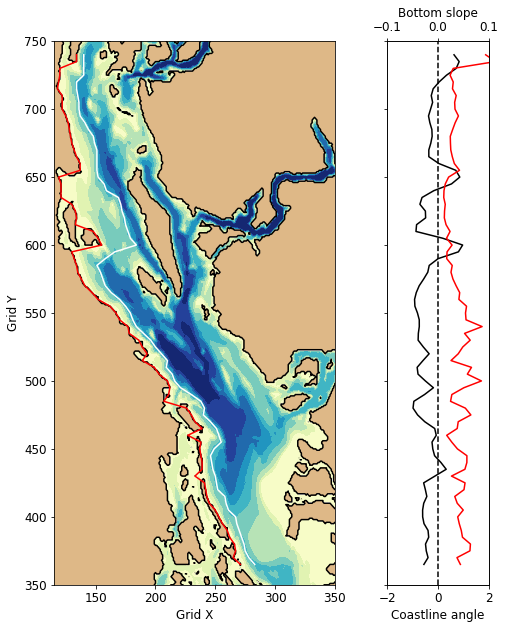

In [6]:
# Plot NEMO coastline and bathymetry
fig, axs = plt.subplots(1, 2, figsize=(8, 10), gridspec_kw={'width_ratios': [3, 1]})
axs[0].set_xlim([115, 350])
axs[0].set_ylim([350, 750])
axs[0].contourf(bathy.Bathymetry, levels=range(0, 451, 50), cmap='YlGnBu', extend='both')
axs[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
axs[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
axs[0].plot(*sections['ji'][::-1], 'r-')
axs[0].plot(sections['ji'][1]+np.nanargmax(bottom, axis=1), sections['ji'][0], 'w-')
axs[0].set_xlabel('Grid X')
axs[0].set_ylabel('Grid Y')
viz_tools.set_aspect(axs[0])

# Plot coastline angle
axs[1].plot([0, 0], [350, 750], 'k--')
axs[1].plot(sections['angle'], sections['ji'][0], 'k-')
axs[1].set_xlim([-2, 2])
axs[1].set_ylim([350, 750])
axs[1].yaxis.set_ticklabels('')
axs[1].set_xlabel('Coastline angle')

# Plot bottom slope
ax2 = axs[1].twiny()
ax2.plot(sections['slope'], sections['ji'][0], 'r-')
ax2.set_xlim([-0.1, 0.1])
ax2.set_xlabel('Bottom slope')
plt.show()

***

## Process NEMO runs

Universal functions

In [7]:
def calc_rho(data, depth, tmask):
    """Calculate the density, rho
    """
    
    tracers = ['vosaline', 'votemper']
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)
    
    return rho

***

### Idealized - 2 layer

Functions specific to idealized processing

In [11]:
def calc_idealized_upwelling_metrics(data, mask, hour, j, i, z_ref, jsub=0, isub=0, angle=0, L=50):
    """
    """
    
    # Extract deptht array
    deptht = mask.gdept_1d[0, :].values
    
    # Calculate stratification parameters
    rho_t0 = calc_rho(
        data.isel(time_counter=0, y=j-jsub, x=slice(i-isub, None)),
        np.expand_dims(deptht, axis=1), mask.tmask[0, :, j, i:],
    )
    rho_ref = rho_t0[abs(deptht - z_ref).argmin(axis=0), :L].mean()

    # Calculate upwelling metrics
    rho = calc_rho(
        data.isel(time_counter=hour, deptht=0, y=j-jsub, x=slice(i-isub, None)),
        0, mask.tmask[0, 0, j, i:],
    )
    rho_max = rho[:L].max()
    z_u = deptht[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0)))]
    x_u = np.cos(angle) * (rho >= rho_ref).sum() * float(mask.e1t[0, j, i])
            
    return z_u, x_u


def process_idealized_results(
    param, sections, mask, grids, hour=24, L=50,
    keys=[], runs={}, vals={}, strat='2layer',
    path='/data/bmoorema/results/Lake/S4d',
    fn='SalishSeaIdeal_1h_20170701_20170706_grid_T.nc',
):
    """
    """

    # Raise ValueError if no keys list
    if not keys: raise ValueError('Must provide list of upwelling parameter keys!')
    
    # Recursively loop through run parameters
    for val in tqdm(param[keys[0]], leave=False, desc=keys[0]):
        vals[keys[0]] = val

        # Continue recursion and define nested dict fields
        if len(keys) > 1:
            runs[val] = {}
            runs[val] = process_idealized_results(
                param, sections, mask, grids, hour=hour, L=L,
                keys=keys[1:], runs=runs[val], vals=vals,
                strat=strat, path=path, fn=fn,
            )

        # Bottom level: stop recursion and process NEMO results
        else:
            runs[val] = {'z_u': [], 'x_u': []}

            # Define and load results file
            if strat is '2layer':
                runID = f"SalishSeaPond_S4d{vals['u_wind']:02d}ms_" + \
                  f"halocline{vals['z_h']:2d}m_rhosurf{vals['rho_s']:4d}"
                z_ref = vals['z_h']
            elif strat is 'const':
                runID = f"SalishSeaPond_S4d{vals['u_wind']:02d}ms_" + \
                  f"N{vals['N']*1e4:04.0f}s"
                z_ref = 10

            file = os.path.join(path, runID, fn)
            if os.path.exists(file):
                with xr.open_dataset(file) as data:

                    # Loop through sections
                    for j, i, a in zip(*sections['ji'], sections['angle']):

                        # Calculate upwelling metrics
                        z_u, x_u = calc_idealized_upwelling_metrics(
                            data, mask, hour, j, i, z_ref, angle=a, L=L,
                            jsub=grids['ideal'][2], isub=grids['ideal'][0],
                        )
                        runs[val]['z_u'].append(z_u)
                        runs[val]['x_u'].append(x_u)

    return runs

Process idealized 2-layer results

In [12]:
# Process idealized 2-layer results
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
}
runs = process_idealized_results(param, sections, mask, grids, keys=['z_h', 'rho_s', 'u_wind'])

Plot idealized 2-layer results

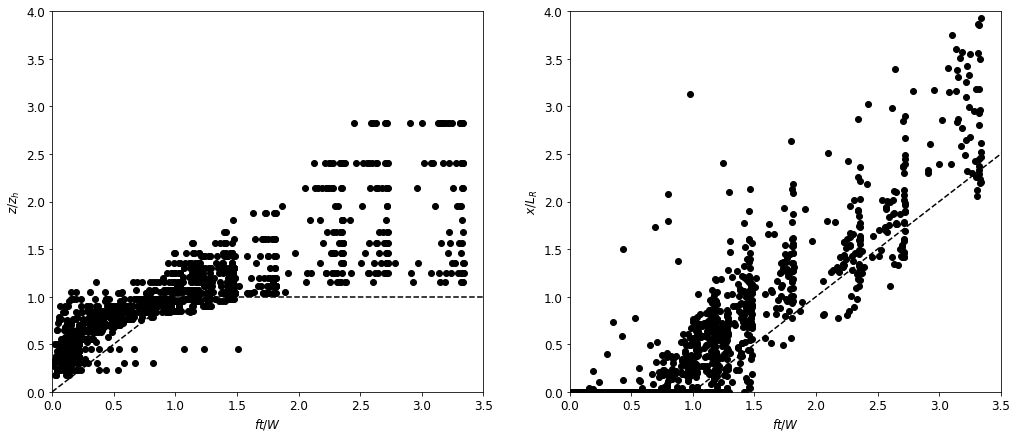

In [13]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)

# Define tau j component
jtau = np.sin(np.arctan(2) - sections['angle']) * (hour - 3) * 3600

# Loop through run parameters
for z_h in param['z_h']:
    for rho_s in param['rho_s']:
        for U, tau in zip(param['u_wind'], param['tau']):
            
            # Define upwelling predictor ft/W
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            L_R = np.sqrt(g_prime * z_h) / const['f']
            ftW = tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
            
            # Plot predictions vs results
            for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
                ax.plot(ftW, np.array(runs[z_h][rho_s][U][var]) / scale, 'ko')

***

### Hindcast - 2 layer

Functions specific to hindcast processing

In [14]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), f'SalishSea_1{res}_{datestr}')
    
    return prefix

#### Determining pycnocline depth

Here I'm using John Klinck's vertical mode calculator `dynmodes` from the [Sea-MAT](https://sea-mat.github.io/sea-mat/) oceanographic tools repository. I specifically use [`dynmodes.py`](https://www.eoas.ubc.ca/~sallen/AIMS-workshop/_modules/dynmodes.html) which was adapted from `dynmodes.m` by Susan Allen.

In [15]:
def plot_verticalmode_diagnostics(
    date, sections, mask, mode='p',
    path='/results2/SalishSea/nowcast-green.201812',
):
    """
    """

    # Define depth array
    deptht = mask.gdept_1d[0, :].values

    # Make figure layout
    fig, axs = plt.subplots(4, 2, figsize=(17, 20), gridspec_kw={'width_ratios': [4, 1]})
    xlims, ylims = [(5, 40), (0, 0.01)], [(-1, 30), (40, 0)]
    if mode is 'r': ylims[0] = (-1, 15)
    xlabels, ylabels = ['grid Z extent', '$N^2$'], ['grid Z zero crossing', 'Depth [m]']

    # Open hindcast record and calc rho
    with xr.open_dataset(make_prefix(date, path) + '_grid_T.nc') as data:

        # Loop through subset of coastline indices
        for row, j, i in zip(axs, sections['ji'][0][::20], sections['ji'][1][::20]):

            # Format panels
            for ax, xlim, ylim, xlabel, ylabel in zip(row, xlims, ylims, xlabels, ylabels):
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_ylabel(ylabel)
                if j < 665: ax.xaxis.set_ticklabels('')
                else: ax.set_xlabel(xlabel)
            row[0].text(0.2, 0.9, f'j = {j}', transform=row[0].transAxes)
            row[0].plot([24, 24], ylims[0], 'k--')
            ax2 = row[1].twiny()
            ax2.plot([0, 0], ylims[1], 'k--')
            if mode is 'p': ax2.set_xlim([-0.2, 0.2])
            elif mode is 'r': ax2.set_xlim([-0.002, 0.002])
            if j > 365: ax2.xaxis.set_ticklabels('')
            else: ax2.set_xlabel('Mode amplitude')

            # Calc rho
            rho = calc_rho(
                data.sel(time_counter=date, method='nearest').isel(y=j, x=slice(i, None)),
                np.expand_dims(deptht, axis=1), mask.tmask[0, :, j, i:],
            )

            # Calc N2
            interp_rho = interp1d(deptht, rho, axis=0, fill_value='extrapolate')
            N2 = const['g'] / const['rho_0'] * np.diff(interp_rho(mask.gdepw_1d[0, :]), axis=0) / \
                np.expand_dims(mask.e3t_1d[0, :-1], axis=1)
            N2 = np.nanmedian(N2[:, :L], axis=1)
            nanindex = ~np.isnan(N2)

            # Plot modes calculations
            for k in range(6, 40):
                _, pmodes, rmodes, _ = dynmodes(N2[nanindex][:k], deptht[:-1][nanindex][:k], 4)
                if mode is 'p': modes = pmodes
                elif mode is 'r': modes = rmodes
                for n, m, color, offset in zip(range(1, 5), modes, ['r', 'm', 'b', 'c'], [-0.15, -0.05, 0.05, 0.15]):
                    if mode is 'p': zindex = np.where(np.diff(np.signbit(m)))[0]
                    elif mode is 'r': zindex = [abs(m).argmax()]
                    if k == 24:
                        row[1].plot(N2[nanindex][:k], deptht[:-1][nanindex][:k], 'k-')
                        ax2.plot(m, deptht[:-1][nanindex][:k], '-', color=color)
                    for count, z in enumerate(zindex):
                        label = None
                        if k == 6: label = f'Mode {n}' if count == 0 else None
                        row[0].plot(k+offset, z, 'ko', markersize=8, markerfacecolor=color, label=label)

    # Legend
    axs[0, 0].legend()

Pycnocline depth using the horizontal velocity modes (*best determined by mode 1 with water column restricted to 40 m depth*).

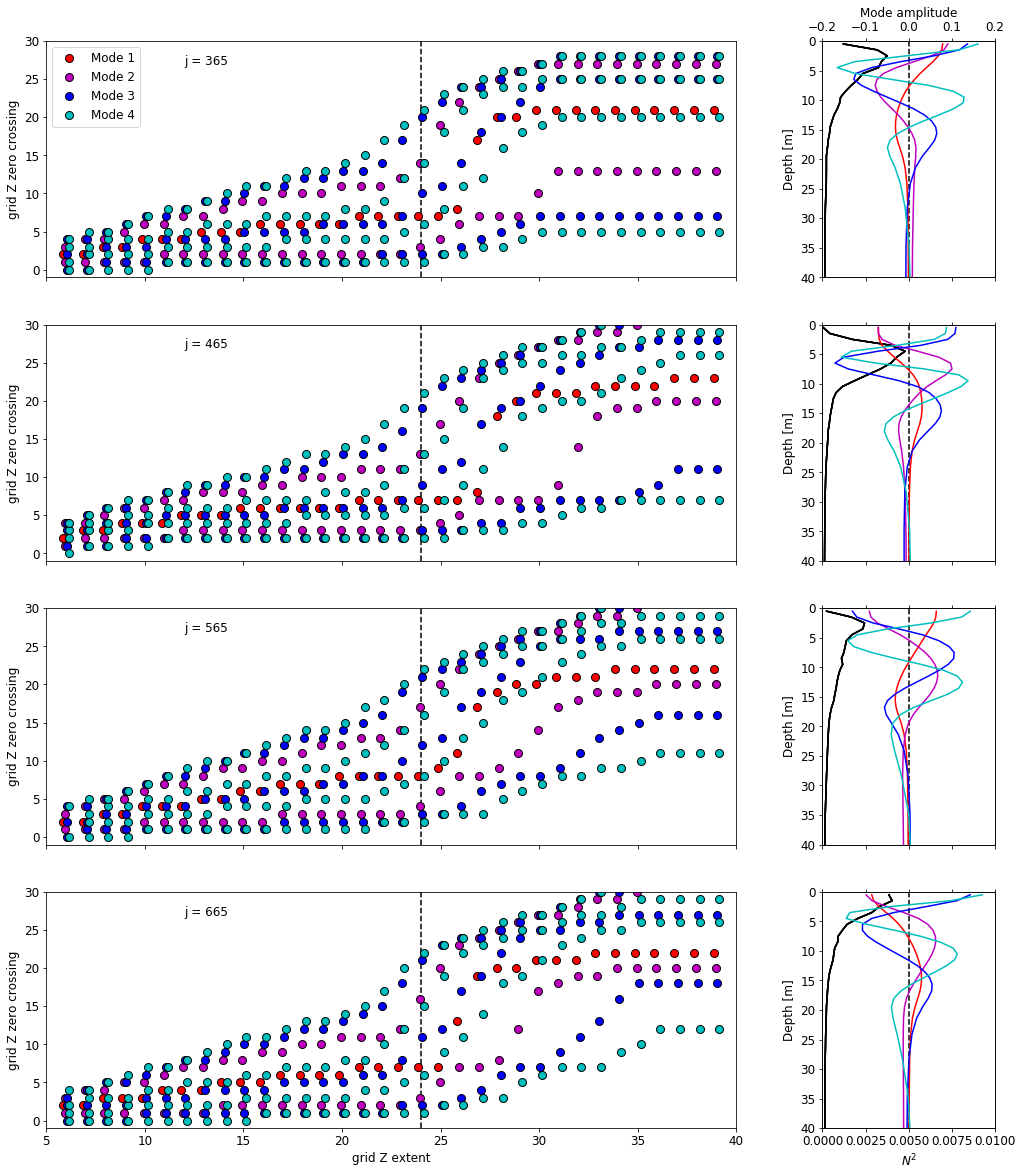

In [16]:
plot_verticalmode_diagnostics(parse(events_southerly[0]), sections, mask, mode='p')

Pycnocline depth using vertical density modes (*more consistent than velocity, but also gives a shallower pycnocline depth*).

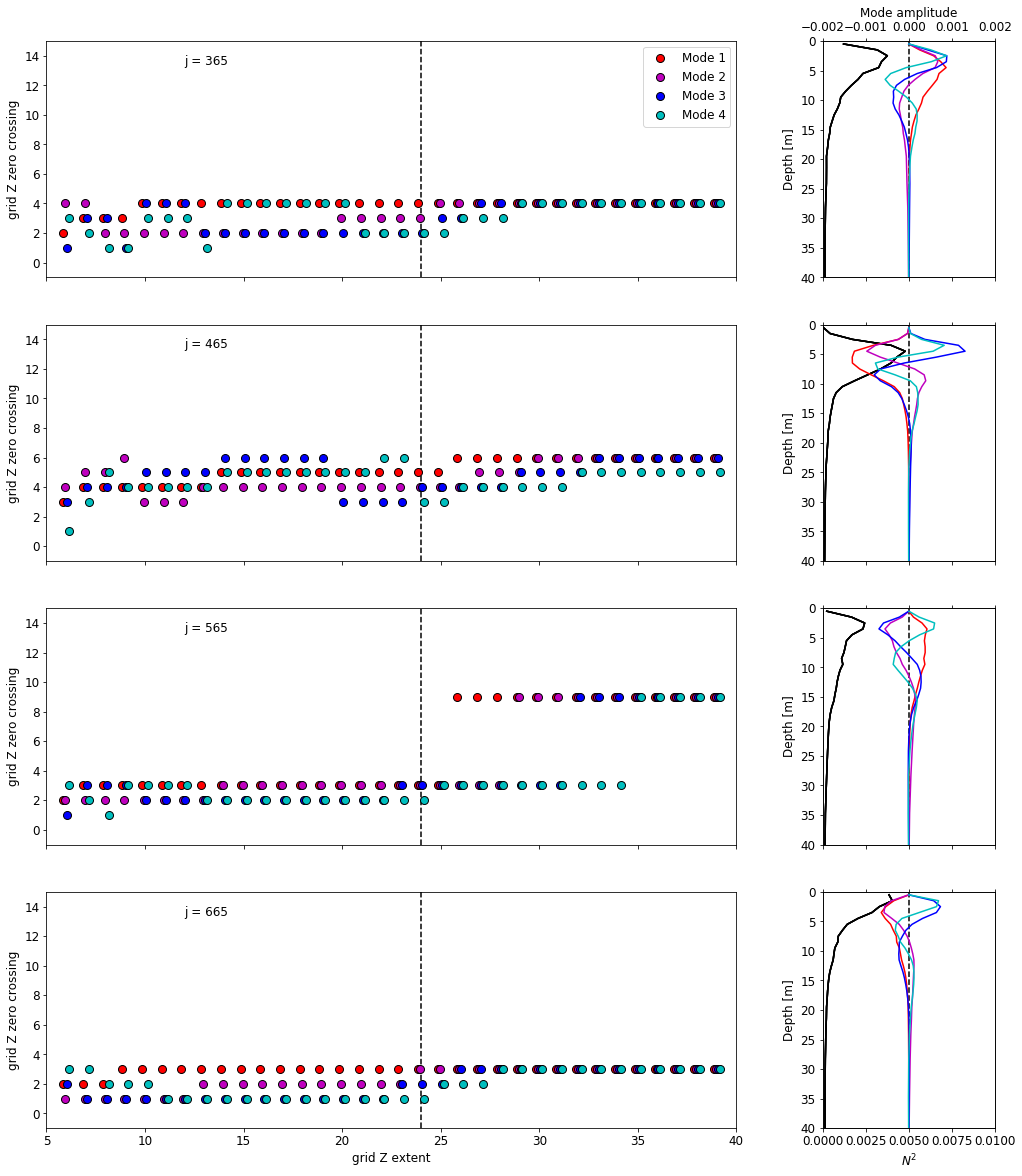

In [17]:
plot_verticalmode_diagnostics(parse(events_southerly[0]), sections, mask, mode='r')

#### Process hindcast

Post-processing functions

In [83]:
def calc_hindcast_upwelling_metrics_t0(data, mask, time, j, i, const, L=50, mode='p'):
    """
    """

    # Construct deptht array
    deptht = mask.gdept_1d[0, :].values
    depthw = mask.gdepw_1d[0, :].values
    e3t = mask.e3t_1d[0, :].values
    
    # Calculate density
    rho_t0 = calc_rho(
        data.sel(time_counter=time, method='nearest').isel(y=j, x=slice(i, None)),
        np.expand_dims(deptht, axis=1), mask.tmask[0, :, j, i:],
    )
    
    # Find average N2 profile on deptht grid within L of coast
    interp_rho = interp1d(deptht, rho_t0, axis=0, fill_value='extrapolate')
    N2 = const['g'] / const['rho_0'] * np.diff(interp_rho(depthw), axis=0) / np.expand_dims(e3t[:-1], axis=1)
    N2 = np.nanmedian(N2[:, :L], axis=1)
    nanindex = np.isnan(N2)
    N2 = N2[~nanindex]
    
    # Calculate pycnocline depth using vertical mode calculator dynmodes
    zlim = min(len(N2), 24)
    _, pmode, rmode, _ = dynmodes(N2[:zlim], deptht[:zlim], 1)
    if mode is 'r': zindex = int(abs(rmode[0, :]).argmax())
    elif mode is 'p': zindex = int(np.where(np.diff(np.signbit(pmode[0, :])))[0])
    else: raise ValueError(f"Can't interpret mode type: {mode}")
    z_h = deptht[zindex]
    
    # Find surface and interface densities, and N values
    rho_s = (rho_t0[:zindex, :L].mean(axis=1) * e3t[:zindex]).sum() / depthw[zindex]
    rho_ref = rho_t0[zindex, :L].mean()
    N_int = (np.sqrt(N2) * e3t[:-1][~nanindex]).sum()
    N_s = (np.sqrt(N2)[:zindex] * e3t[:zindex]).sum() / depthw[zindex]
    
    return z_h, rho_s, rho_t0, rho_ref, N_int, N_s


def calc_hindcast_upwelling_metrics_t1(data, mask, timerange, j, i, HRDPS, jj, ii, rho_t0, rho_ref, angle=0, L=50):
    """
    """

    # Construct depth arrays
    deptht = mask.gdept_1d[0, :].values
    
    # Calculate tau
    u, v = [
        HRDPS.sel(time=slice(*timerange))[k].values[:, jj, slice(ii, ii+10)]
        for k in ['u_wind', 'v_wind']
    ]
    jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180) + angle)
    tau = sum(1.225e-3 * (jtau * np.sqrt(u**2 + v**2)).mean(axis=1)**2) * 3600

    # Calculate upwelling metrics
    rho = calc_rho(
        data.sel(time_counter=timerange[1], method='nearest').isel(deptht=0, y=j, x=slice(i, None)),
        0, mask.tmask[0, 0, j, i:],
    )
    rho_max = rho[:L].max()
    z_u = deptht[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0)))]
    x_u = np.cos(angle) * (rho[:L].compressed() >= rho_ref).sum() * float(mask.e1t[0, j, i])
    
    return z_u, x_u, tau


def process_hindcast_results(
    events, sections, mask, HRDPS, hour=24, L=50,
    const={'g': 9.81, 'rho_0': 1e3},
    path='/results2/SalishSea/nowcast-green.201812',
):
    """
    """
    
    # Initialize variables storage and parse dates
    varnames = ['rho_s', 'z_h', 'N_int', 'N_s', 'tau', 'z_u', 'x_u']
    outnames = [
        ('z_h', 'rho_s', 'rho_t0', 'rho_ref', 'N_int', 'N_s'),
        ('z_u', 'x_u', 'tau'),
    ]
    variables = {}
    for var in varnames: variables[var] = np.empty((0, sections['n']))
    dates = np.array([parse(date) for date in events])
    
    # Loop through upwelling event dates
    for date in tqdm(dates):
        
        # Define loop variables
        datestr = date.strftime('%Y%b%d')
        varlist = {'rho_t0': [], 'rho_ref': []}
        for var in varnames: varlist[var] = []

        # Loop through hours
        for hour in [0, hour]:
            time = date + timedelta(hours=hour)

            # Open hindcast record
            with xr.open_dataset(make_prefix(time, path) + '_grid_T.nc') as data:

                # Loop through sections
                for n, j, i, jj, ii, a in zip(
                    range(sections['n']), *sections['ji'], *sections['ji_HRDPS'], sections['angle'],
                ):

                    # Calculations at t=0
                    if hour == 0:

                        # Calculate stratification parameters
                        outputs = calc_hindcast_upwelling_metrics_t0(data, mask, time, j, i, const, L=L)

                        # Append to dict lists
                        for var, out in zip(outnames[0], outputs):
                            varlist[var].append(out)

                    # Calculations at hours
                    else:

                        # Calculate upwelling parameters
                        outputs = calc_hindcast_upwelling_metrics_t1(
                            data, mask, [date, time], j, i, HRDPS, jj, ii,
                            varlist['rho_t0'][n], varlist['rho_ref'][n], angle=a, L=L,
                        )

                        # Append to dict lists
                        
                        for var, out in zip(outnames[1], outputs):
                            varlist[var].append(out)
        
        # Concatenate lists onto storage arrays
        for var in varnames:
            variables[var] = np.concatenate((variables[var], np.expand_dims(varlist[var], axis=0)))
            
    # Compile storage arrays into xarray dataset
    for var in varnames: variables[var] = (['date', 'y'], variables[var])
    ds = xr.Dataset(variables, coords={'date': dates, 'y': sections['ji'][0]})
                        
    return ds

Process hindcast results

In [86]:
# Process hindcast results
runs = process_hindcast_results(events_southerly, sections, mask, HRDPS)

Plot hindcast results

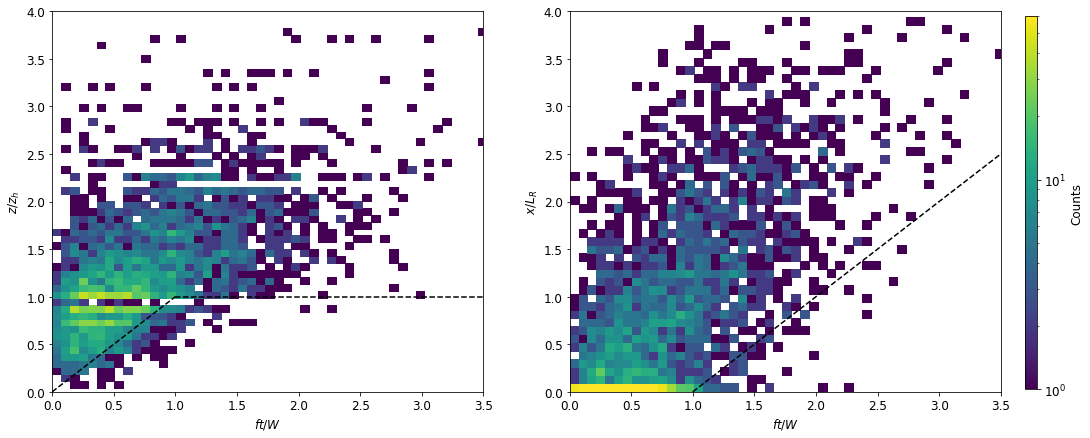

In [93]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cax = fig.add_axes([0.92, 0.13, 0.01, 0.74])
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')
            
# Define upwelling predictor ft/W
g_prime = const['g'] * (const['rho_0'] - runs.rho_s) / const['rho_0']
L_R = np.sqrt(g_prime * runs.z_h) / const['f']
ftW = runs.tau / (const['rho_0'] * runs.z_h * np.sqrt(g_prime * runs.z_h))

# Plot predictions vs results
for ax, y in zip(axs, [runs.z_u / runs.z_h, runs.x_u / L_R]):
    _, _, _, c = ax.hist2d(ftW.values.flatten(), y.values.flatten(), norm=colors.LogNorm(vmin=1, vmax=60), bins=70)

# Format plot
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)
    
# Colorbar
fig.colorbar(c, cax=cax, label='Counts')